In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

FIRST LOAD THE SEGMENTATION MODEL

In [2]:
class MyLosses(object):

  def weighted_crossentropy(self, class_weights):
      def loss_fn(y_true, y_pred):
          # Apply softmax activation to logits
          y_pred = tf.nn.softmax(y_pred, axis=-1)

          # Flatten both inputs
          y_true_f = tf.reshape(y_true, [-1])
          y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

          # Calculate weighted cross-entropy loss
          loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.cast(y_true_f, dtype=tf.int32), logits=y_pred_f)
          weighted_loss = tf.reduce_mean(tf.multiply(loss, tf.gather(class_weights, tf.cast(y_true_f, dtype=tf.int32))))

          return weighted_loss

      return loss_fn
  
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Leaf Only', 'Disease Only']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

myloss = MyLosses()
loss = myloss.weighted_crossentropy(tf.constant([1.0, 5.33, 16.0]))
# learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-21 13:21:58.132230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-21 13:21:58.132786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
class SegmentationModel():

  def __init__(self, path):
    self.model = tf.keras.models.load_model(
      path, compile=False, options=None
    )
    self.model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=loss,
      metrics=["accuracy"],
    )

  def segment(self, image):
    image = cv2.resize(image, (512, 512))
    mask = create_mask(self.model.predict(image[tf.newaxis, ...]))
    leaf = cv2.bitwise_and(image, image, mask=cv2.inRange(mask.numpy(), 1, 2))
    disease = cv2.bitwise_and(image, image, mask=cv2.inRange(mask.numpy(), 2, 2))
    return (disease, leaf)



class ClassificationModel():
  DISEASE_CLASSES = ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
  def __init__(self, path):
    self.model = tf.keras.models.load_model(path, compile=False)
    self.model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
  def classify(self,img): 
    img = cv2.resize(img, (180,180))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = self.model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    prediction = self.DISEASE_CLASSES[np.argmax(score)]
    confidence = 100 * np.max(score)
    return prediction, confidence


SEGMENT THEN CLASSIFY

2023-03-21 13:31:42.694429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 835ms/step


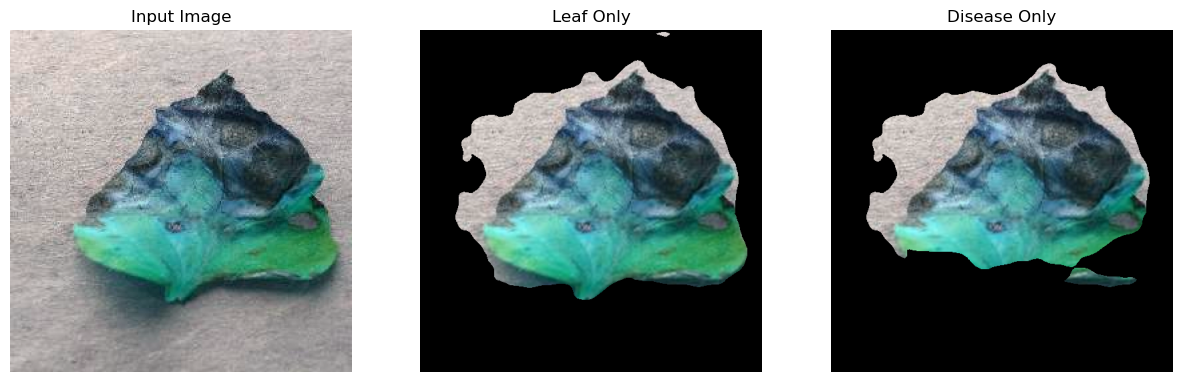

1/1 [==============================] - 0s 92ms/step
Septoria_leaf_spot 94.62198615074158


2023-03-21 13:31:44.062578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [13]:
# load image
img_path = 'COCOdatasettomato/images/train/image (17).JPG'
img = cv2.imread(img_path)

# get disease
seg_model = SegmentationModel('saved_seg_models/model2023-03-18 15_39_47.663348/')
diseased, leaf = seg_model.segment(img)
display([img, leaf, diseased])

# classify
classify_model = ClassificationModel('saved_model/model_seg_class2023-03-21 16:26:22.583441')
classification, confidence = classify_model.classify(diseased)
print(classification, confidence)

In [6]:
import pathlib
import os
import cv2
import PIL

# source directory
dataset_dir = 'dataset'

train_dir = os.path.join(dataset_dir, 'train')
train_dir = pathlib.Path(train_dir)
val_dir = os.path.join(dataset_dir, 'valid')
val_dir = pathlib.Path(val_dir)

# destination directory
dest_dir = '/Users/vedmahadeo/Documents/Programming/FoliageFixerModel/segmented-dataset'

seg_model = SegmentationModel('saved_seg_models/model2023-03-18 15_39_47.663348')

# train set
# for disease_folder in train_dir.iterdir():
#   disease_name = str(disease_folder).replace(str(train_dir)+'/', '')
#   images = []
#   for ext in ['*.jpg', '*.jpeg', '*.JPG', '*.png']:
#     images.extend(pathlib.Path(disease_folder).glob(ext))
#   for image in images:
#     img_path = str(image)
#     filename = img_path.replace(str(disease_folder)+'/', '')
#     filename = filename.replace('.jpg', '.png')
#     filename = filename.replace('.JPG', '.png')
#     filename = filename.replace('.jpeg', '.png')
#     image = cv2.imread(img_path)
#     disease, leaf = seg_model.segment(image)
#     save_path = os.path.join(dest_dir+'/train/'+disease_name, filename)
#     result = cv2.imwrite(save_path, disease.astype(dtype='uint8'))

# validation set
for disease_folder in val_dir.iterdir():
  disease_name = str(disease_folder).replace(str(val_dir)+'/', '')
  images = []
  for ext in ['*.jpg', '*.jpeg', '*.JPG', '*.png']:
    images.extend(pathlib.Path(disease_folder).glob(ext))
  for image in images:
    img_path = str(image)
    filename = img_path.replace(str(disease_folder)+'/', '')
    filename = filename.replace('.jpg', '.png')
    filename = filename.replace('.JPG', '.png')
    filename = filename.replace('.jpeg', '.png')
    image = cv2.imread(img_path)
    disease, leaf = seg_model.segment(image)
    save_path = os.path.join(dest_dir+'/val/'+disease_name, filename)
    result = cv2.imwrite(save_path, disease.astype(dtype='uint8'))

2023-03-20 21:51:29.953323: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-20 21:51:30.279576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 72ms/step
